In [1]:
from google.colab import drive
import sys
import os
import random
import numpy as np
import cv2

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/Brain_Tumor'
batch = 32
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

#Loading Data

In [3]:
import os
import cv2
#DataFolders
data_folder = "/content/drive/My Drive/Colab Notebooks/Brain_Tumor/Testing"

data_pituitary = data_folder + "/pituitary_tumor/"
data_no_tumor = data_folder + "/no_tumor/"
data_meningioma = data_folder + "/meningioma_tumor/"
data_glioma = data_folder + "/glioma_tumor/"

In [4]:
RESIZE_TO = 224

x, y = [], []
for path in [f for f in os.listdir(data_pituitary) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_pituitary + path), (RESIZE_TO, RESIZE_TO)))
    y.append("pituitary")
for path in [f for f in os.listdir(data_no_tumor) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_no_tumor + path), (RESIZE_TO, RESIZE_TO)))
    y.append("no_tumor")
for path in [f for f in os.listdir(data_meningioma) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_meningioma + path), (RESIZE_TO, RESIZE_TO)))
    y.append("meningioma")
for path in [f for f in os.listdir(data_glioma) if f[-4:] == ".jpg"]:
    x.append(cv2.resize(cv2.imread(data_glioma + path), (RESIZE_TO, RESIZE_TO)))
    y.append("glioma")


In [5]:
print(' Number of Pituitary Tumors:', len(os.listdir(data_pituitary)))
print(' Number of No Tumors:', len(os.listdir(data_no_tumor)))
print(' Number of Meningioma Tumors:', len(os.listdir(data_meningioma)))
print(' Number of Glioma Tumors:', len(os.listdir(data_glioma)))

 Number of Pituitary Tumors: 74
 Number of No Tumors: 105
 Number of Meningioma Tumors: 115
 Number of Glioma Tumors: 100


In [6]:
#y_test
from sklearn.preprocessing import LabelEncoder
y = np.array(y)
le = LabelEncoder()
le.fit(["pituitary", "no_tumor", "meningioma", "glioma"])
y = le.transform(y)

In [7]:
RESIZE_TO = 299

x_299 = []
for path in [f for f in os.listdir(data_pituitary) if f[-4:] == ".jpg"]:
    x_299.append(cv2.resize(cv2.imread(data_pituitary + path), (RESIZE_TO, RESIZE_TO)))
for path in [f for f in os.listdir(data_no_tumor) if f[-4:] == ".jpg"]:
    x_299.append(cv2.resize(cv2.imread(data_no_tumor + path), (RESIZE_TO, RESIZE_TO)))
for path in [f for f in os.listdir(data_meningioma) if f[-4:] == ".jpg"]:
    x_299.append(cv2.resize(cv2.imread(data_meningioma + path), (RESIZE_TO, RESIZE_TO)))
for path in [f for f in os.listdir(data_glioma) if f[-4:] == ".jpg"]:
    x_299.append(cv2.resize(cv2.imread(data_glioma + path), (RESIZE_TO, RESIZE_TO)))


In [8]:
#Xception
x_cept = np.array(x_299)
x_cept = tf.keras.applications.xception.preprocess_input(x_cept, data_format = None)

In [9]:
#Resnet
x_res = np.array(x)
x_res = tf.keras.applications.resnet.preprocess_input(x_res, data_format = None)

#Loading Resnet Model

In [10]:
#Loading Resnet Model

# Add the pretrained layers
pretrained_model = keras.applications.ResNet50(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 
drop = keras.layers.Dropout(0.4)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)

# Get the model
model_1 = keras.Model(inputs=pretrained_model.input, outputs=output)

#model_1.summary()

In [11]:
#Load the saved model
model_1.load_weights(filepath=abspath_curr + '/result/ResNet50_model/model.h5')

# Compile the model
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',    
              metrics=['accuracy'])

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["pituitary", "no_tumor", "meningioma", "glioma"]

y_pred_res = model_1.predict(x_res)
pred_res = np.argmax(y_pred_res, axis=1)

print(classification_report(y, pred_res, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y, pred_res) * 100)
print("\n")

              precision    recall  f1-score   support

   pituitary       1.00      0.26      0.41       100
    no_tumor       0.69      0.97      0.80       115
  meningioma       0.71      0.98      0.82       105
      glioma       0.94      0.78      0.85        74

    accuracy                           0.76       394
   macro avg       0.83      0.75      0.72       394
weighted avg       0.82      0.76      0.72       394

Accuracy :  75.63451776649747




#Loading Xception Model

In [13]:
#Loading Xception Model

# Add the pretrained layers
pretrained_model = keras.applications.Xception(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout 50%
drop = keras.layers.Dropout(0.5)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)

# Get the model
model_2 = keras.Model(inputs=pretrained_model.input, outputs=output)

#model_2.summary()

In [14]:
# Load the saved model
model_2.load_weights(filepath=abspath_curr + '/result/Xception_model/model.h5')

# Compile the model
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names_tr = ["pituitary", "no_tumor", "meningioma", "glioma"]

y_pred_xcept = model_2.predict(x_cept)
pred_xcept = np.argmax(y_pred_xcept, axis=1)
print(classification_report(y, pred_xcept, target_names=class_names_tr))
print("Accuracy : ", accuracy_score(y, pred_xcept) * 100)
print("\n")

              precision    recall  f1-score   support

   pituitary       1.00      0.29      0.45       100
    no_tumor       0.68      1.00      0.81       115
  meningioma       0.79      1.00      0.88       105
      glioma       0.95      0.80      0.87        74

    accuracy                           0.78       394
   macro avg       0.85      0.77      0.75       394
weighted avg       0.84      0.78      0.75       394

Accuracy :  78.1725888324873




In [16]:
#Loading VGG16 Model

# Add the pretrained layers
pretrained_model = keras.applications.VGG16(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout
drop = keras.layers.Dropout(0.4)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(4, activation='softmax')(dropout)
model_3 = keras.Model(inputs=pretrained_model.input, outputs=output)

# Load the saved model
model_3.load_weights(filepath=abspath_curr + '/result/VGG16_model/model.h5')

# Compile the model
model_3.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Classification report - VGG16
y_pred_VGG16 = model_3.predict(x_res)
pred_VGG16 = np.argmax(y_pred_VGG16, axis=1)
print(classification_report(y, pred_VGG16, target_names=class_names_tr))
print('VGG16 Results')
print("Accuracy : ", accuracy_score(y, pred_VGG16) * 100)
print("\n")

              precision    recall  f1-score   support

   pituitary       0.93      0.27      0.42       100
    no_tumor       0.67      0.92      0.77       115
  meningioma       0.64      0.99      0.78       105
      glioma       0.98      0.57      0.72        74

    accuracy                           0.71       394
   macro avg       0.80      0.69      0.67       394
weighted avg       0.78      0.71      0.67       394

VGG16 Results
Accuracy :  70.81218274111674




In [17]:
import pandas as pd
#Combining the models
df1 = pd.DataFrame(y_pred_res, columns = ["pituitary1", "no_tumor1", "meningioma1", "glioma1"])
df2 = pd.DataFrame(y_pred_xcept, columns = ["pituitary2", "no_tumor2", "meningioma2", "glioma2"])
df3 = pd.DataFrame(y_pred_VGG16, columns = ["pituitary3", "no_tumor3", "meningioma3", "glioma3"])
df_target = pd.DataFrame(y, columns = ['target'])

df1['pituitary2'] = df2['pituitary2']
df1['no_tumor2'] = df2['no_tumor2']
df1['meningioma2'] = df2['meningioma2']
df1['glioma2'] = df2['glioma2']

df1['pituitary3'] = df3['pituitary3']
df1['no_tumor3'] = df3['no_tumor3']
df1['meningioma3'] = df3['meningioma3']
df1['glioma3'] = df3['glioma3']

df1['target'] = df_target['target']


In [18]:
#https://github.com/amir-jafari/Data-Mining/blob/master/9-Random%20Forest/1-Example_Exercise/RF_1.py
# %%%%%%%%%%%%% Random Forest  %%%%%%%%%%%%%%%%%%%%%%%%%%
#%%-----------------------------------------------------------------------
# Importing the required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [19]:
# import Dataset
# read data as panda dataframe
data = df1

# printing the dataswet rows and columns
print("Dataset No. of Rows: ", data.shape[0])
print("Dataset No. of Columns: ", data.shape[1])

# printing the dataset obseravtions
print("Dataset first few rows:\n ")
print(data.head(2))

Dataset No. of Rows:  394
Dataset No. of Columns:  13
Dataset first few rows:
 
     pituitary1  no_tumor1  meningioma1  ...  meningioma3   glioma3  target
0  1.142970e-04   0.057181     0.000044  ...     0.050142  0.438105       3
1  3.662360e-08   0.001411     0.000004  ...     0.002329  0.997569       3

[2 rows x 13 columns]


In [20]:
#clean the dataset
print("Sum of NULL values in each column. ")
print(data.isnull().sum())

Sum of NULL values in each column. 
pituitary1     0
no_tumor1      0
meningioma1    0
glioma1        0
pituitary2     0
no_tumor2      0
meningioma2    0
glioma2        0
pituitary3     0
no_tumor3      0
meningioma3    0
glioma3        0
target         0
dtype: int64


In [21]:
#split the dataset
# separate the predictor and target variable
X = data.values[:, 0:12]
Y = data.values[:, 12]

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [22]:
#perform training with random forest with all columns
# specify random forest classifier
clf = RandomForestClassifier(n_estimators=100)

# perform training
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
# predicton on test using all features
y_pred = clf.predict(X_test)
y_pred_score = clf.predict_proba(X_test)

In [24]:
# calculate metrics gini model

print("\n")
print("Results Using All Features: \n")

print("Classification Report: ")
print(classification_report(y_test,y_pred))
print("\n")

print("Accuracy : ", accuracy_score(y_test, y_pred) * 100)
print("\n")

#print("ROC_AUC : ", roc_auc_score(y_test,y_pred_score[:,1]) * 100)




Results Using All Features: 

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.85      0.77      0.81        30
         1.0       0.91      0.91      0.91        33
         2.0       0.91      0.97      0.94        32
         3.0       0.96      1.00      0.98        24

    accuracy                           0.91       119
   macro avg       0.91      0.91      0.91       119
weighted avg       0.91      0.91      0.91       119



Accuracy :  90.75630252100841




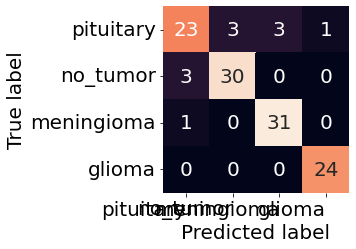

In [25]:
# confusion matrix for gini model
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = ["pituitary", "no_tumor", "meningioma", "glioma"]


df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names )

plt.figure(figsize=(5,5))

hm = sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='d', annot_kws={'size': 20}, yticklabels=df_cm.columns, xticklabels=df_cm.columns)

hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=20)
plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
# Show heat map
plt.tight_layout()

